# Good Crop Bad Crop

### Mask creation

Initial mask creation done manually with the possibility of creating masks using a tool in the future. (One field mask creation)

Issues:
- Different fields will have different pixel counts, need to compress last fields/expand small fields.  Suggestion: Analyse fields across dataset and determine average size in pixels, initially just use chosen field size

In [1]:
#imports
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from datetime import datetime
import copy
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
tile_x = 5120
tile_y = 3584
band = 'TCI' #photo
time_period = '2019-07-20'
TCI_filename = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-{band}-{time_period}.png"
mask_filename = f"./satelite_data/Phase02DataDelivery/masks/mask-x{tile_x}-y{tile_y}.png"

#np.array(TCI_image.resize((100, 100)).getdata())
TCI_image = Image.open(TCI_filename)
TCI_image

FileNotFoundError: [Errno 2] No such file or directory: './satelite_data/Phase02DataDelivery/sugarcanetiles/5120-3584-TCI-2019-07-20.png'

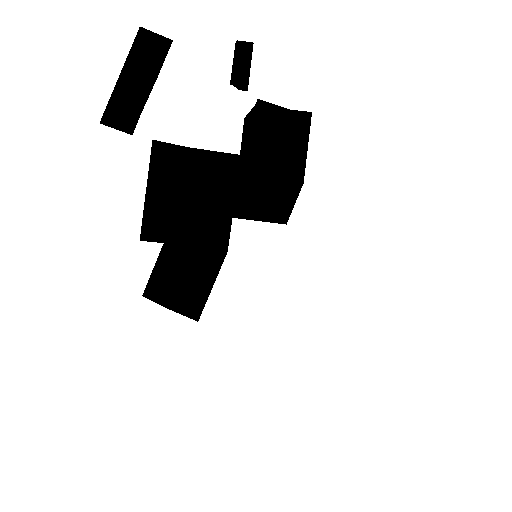

In [3]:
mask_image = Image.open(mask_filename)
mask_image

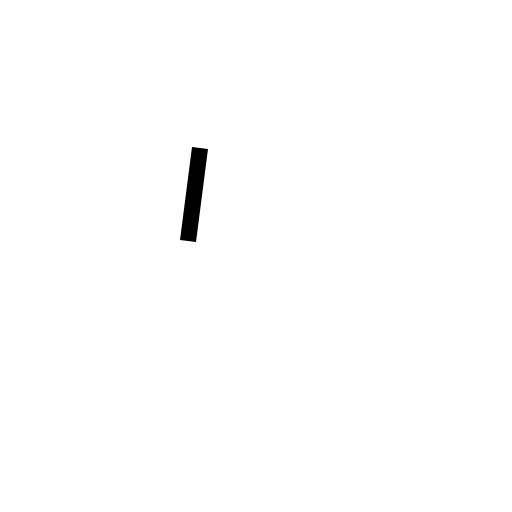

In [4]:
# manually created in photoshop a mask for a single field:

field_mask_filename = f"./satelite_data/{tile_x}-{tile_y}-SingleFieldMask.png"
field_mask_image = Image.open(field_mask_filename)
field_mask_image

In [5]:
TCI_image =  np.array(TCI_image.resize((100, 100)).getdata()).reshape(100,100,3)/255
print(TCI_image.shape)
field_mask_image = np.array(field_mask_image.resize((100, 100)).getdata())[:,3].reshape(100,100,1)/255
field_mask_image.shape

(100, 100, 3)


(100, 100, 1)

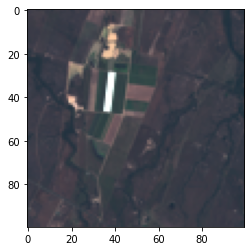

In [6]:
plt.imshow(np.minimum(TCI_image + field_mask_image,1))

In [7]:
#now that we have a mask, let us load all of the related image, and store them in a dataframe with each row being a date

location_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-{band}*.png"
location_times = glob.glob(location_path)

for i in range(0,len(location_times)):
    location_times[i] = location_times[i][-14:-4]
    
        

In [9]:
df = pd.DataFrame()

bool_mask = (field_mask_image == 1.0).reshape(100,100)

colour_names = ['R','G','B','A']
mask_pixels = np.sum(bool_mask)

for time_period in location_times:
    row_dict = {'Time': datetime.strptime(time_period, '%Y-%m-%d')}
    for i in range(1,13):
        file_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B{i:02d}-{time_period}.png"
        image_file = Image.open(file_path)
        image_file =  np.array(image_file.resize((100, 100)).getdata()).reshape(100,100)
        ravel_pixels = image_file[bool_mask].ravel()
        layer_count = ravel_pixels.shape[0]/mask_pixels
        field_pixels = np.median(ravel_pixels)
        if(layer_count == 1):
            row_dict[f'B{i:02d}'] = ravel_pixels
        else:
            ravel_pixels = ravel_pixels.reshape(-1,layer_count)
            for j in range(0,layer_count):
                row_dict[f'TCI {colour_names[j]}'] = ravel_pixels[:,j]

    # add TCI
    file_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-TCI-{time_period}.png"
    image_file = Image.open(file_path)
    image_file = np.array(image_file.resize((100, 100)).getdata()).reshape(100,100,3)/255
    ravel_pixels = image_file[bool_mask].ravel()
    layer_count = int(ravel_pixels.shape[0]/mask_pixels)
    ravel_pixels = ravel_pixels.reshape(-1,layer_count)
    for j in range(0,layer_count):
        row_dict[f'TCI {colour_names[j]}'] = ravel_pixels[:,j]
    
    df = df.append(row_dict, ignore_index=True)


In [10]:
df.head(3)

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,B12,TCI B,TCI G,TCI R,Time
0,"[3228, 3179, 3185, 3165, 3255, 3427, 3774, 352...","[2828, 2795, 2606, 2668, 2556, 2877, 3359, 320...","[2686, 2692, 2370, 2509, 2267, 2698, 3162, 300...","[2779, 2732, 2321, 2482, 2187, 2822, 3434, 317...","[3097, 3142, 2587, 2813, 2410, 3106, 3662, 340...","[4129, 4534, 3430, 4004, 3148, 3971, 4220, 414...","[4682, 5181, 3852, 4543, 3524, 4463, 4666, 461...","[4515, 4958, 3577, 4264, 3228, 4122, 4427, 441...","[1112, 1112, 978, 1025, 995, 1137, 1373, 1216,...","[28, 30, 28, 29, 27, 27, 31, 26, 31, 27, 30, 3...","[5170, 5309, 3922, 4471, 3475, 4872, 5955, 534...","[3425, 3545, 2496, 2864, 2247, 3212, 3987, 353...","[0.4, 0.396078431372549, 0.3686274509803922, 0...","[0.3803921568627451, 0.3803921568627451, 0.337...","[0.39215686274509803, 0.38823529411764707, 0.3...",2017-09-28
1,"[2735, 2813, 2812, 2860, 2918, 2978, 2967, 299...","[2235, 2343, 2325, 2383, 2578, 2645, 2717, 261...","[2092, 2235, 2202, 2299, 2528, 2640, 2771, 260...","[1919, 2123, 2104, 2209, 2598, 2773, 3042, 272...","[2421, 2584, 2593, 2687, 3082, 3274, 3569, 323...","[3690, 3900, 3989, 4122, 4583, 4817, 5068, 473...","[4251, 4463, 4606, 4753, 5269, 5529, 5805, 542...","[4089, 4281, 4445, 4582, 5120, 5362, 5693, 523...","[1317, 1337, 1407, 1393, 1544, 1619, 1680, 160...","[28, 30, 32, 31, 34, 33, 34, 32, 34, 36, 34, 3...","[3873, 4094, 4338, 4396, 5340, 5758, 6353, 568...","[2380, 2705, 2857, 2997, 3913, 4350, 4810, 429...","[0.3176470588235294, 0.3333333333333333, 0.329...","[0.2980392156862745, 0.3176470588235294, 0.313...","[0.27058823529411763, 0.30196078431372547, 0.2...",2018-08-14
2,"[3129, 3141, 3143, 3159, 3253, 3352, 3300, 336...","[2917, 2787, 2863, 2811, 2994, 3140, 3231, 313...","[2848, 2686, 2767, 2707, 2930, 3142, 3293, 311...","[3407, 3143, 3286, 3153, 3511, 3800, 4080, 376...","[3694, 3387, 3566, 3400, 3786, 4092, 4364, 407...","[4055, 3718, 3921, 3772, 4159, 4514, 4884, 448...","[4409, 4089, 4297, 4136, 4541, 4913, 5368, 488...","[4344, 3967, 4216, 4020, 4447, 4826, 5268, 476...","[1474, 1373, 1454, 1370, 1532, 1609, 1759, 161...","[32, 32, 32, 31, 33, 32, 29, 29, 28, 28, 30, 2...","[6150, 5481, 5949, 5490, 6261, 6782, 7294, 670...","[5164, 4540, 4992, 4621, 5319, 5876, 6197, 581...","[0.4117647058823529, 0.396078431372549, 0.4039...","[0.403921568627451, 0.3803921568627451, 0.3921...","[0.4823529411764706, 0.44313725490196076, 0.46...",2018-06-05


### Prepare data for model

In [11]:
# order by date and max target variable following period

rows_before_shift = df.shape[0]
df.sort_values(by='Time', ignore_index=True, inplace=True)

df_copy = copy.deepcopy(df) #hack to not lose row from next line of code

In [45]:
offset = 5
df = copy.deepcopy(df_copy)  #hack for debugging, not needed

NDVI = (df['B08'] - df['B03'])/(df['B08'] + df['B03'])

NDVI_shift = np.array(NDVI[offset:])
time_shift = np.array(df['Time'][offset:])
for i in range(0,offset):
    NDVI_shift = np.append(NDVI_shift,None)
    time_shift = np.append(time_shift,None)
df['NDVI'] = NDVI
df['TimeBetween'] = time_shift
df['TimeBetween'] = pd.to_datetime(df['TimeBetween']) - df['Time']

df['Target NDVI'] = NDVI_shift

df = df[:rows_before_shift-offset].reset_index()

df['Time'] = (df['Time'].dt.month).astype('category')
df['TimeBetween'] = df['TimeBetween'].astype('timedelta64[D]')
df.tail(1)

,index,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,B12,TCI B,TCI G,TCI R,Time,NDVI,TimeBetween,Target NDVI
65,65,"[2762, 2775, 2765, 2782, 2769, 2779, 2814, 279...","[2164, 2164, 2177, 2180, 2182, 2184, 2203, 219...","[2116, 2153, 2151, 2164, 2168, 2176, 2220, 219...","[1236, 1257, 1280, 1287, 1294, 1293, 1329, 131...","[2100, 2145, 2164, 2150, 2187, 2182, 2273, 222...","[5742, 5696, 5704, 5640, 5647, 5792, 5740, 566...","[7293, 7155, 7220, 7078, 7063, 7214, 7156, 703...","[6885, 6685, 6781, 6624, 6624, 6748, 6714, 660...","[1140, 1132, 1109, 1139, 1092, 1101, 1082, 110...","[21, 17, 21, 21, 22, 21, 18, 19, 20, 19, 24, 2...","[3404, 3366, 3428, 3416, 3452, 3504, 3557, 351...","[1312, 1292, 1335, 1317, 1348, 1362, 1422, 138...","[0.30980392156862746, 0.3058823529411765, 0.30...","[0.30196078431372547, 0.3058823529411765, 0.30...","[0.17647058823529413, 0.1803921568627451, 0.18...",6,"[0.5298300188867904, 0.512785698121747, 0.5183...",60.0,"[0.4466114774800056, 0.42943635577338907, 0.43..."


In [46]:
expanded_by_pixel = pd.DataFrame()

cols = df.columns
for index, row in df.iterrows():
    for pixel in range(0, mask_pixels):
        expanded_dict = {'Time': row['Time'], 
                         'TimeBetween': row['TimeBetween'], 
                         'Pixel':pixel}
        for col in cols:
            if(col != 'Time' and col != 'TimeBetween' and col != 'index'):
                expanded_dict[col] = row[col][pixel]
        expanded_by_pixel = expanded_by_pixel.append(expanded_dict, ignore_index=True)

expanded_by_pixel['Time'] = expanded_by_pixel['Time'].astype('category') 
# one hot encode the months (Time column)
expanded_by_pixel = pd.get_dummies(expanded_by_pixel) 

expanded_by_pixel.shape

(1848, 31)

In [47]:
expanded_by_pixel.head(1)

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,...,Time_3.0,Time_4.0,Time_5.0,Time_6.0,Time_7.0,Time_8.0,Time_9.0,Time_10.0,Time_11.0,Time_12.0
0,3850.0,3662.0,3612.0,4162.0,4293.0,5024.0,5745.0,5414.0,849.0,27.0,...,0,0,0,0,0,0,0,0,0,1


### Normalisation

In [48]:
target = expanded_by_pixel['Target NDVI'].values
Data = expanded_by_pixel.drop(columns='Target NDVI').values

# normalise data using a min-max scaler
Data = preprocessing.MinMaxScaler().fit_transform(Data)

print(Data.shape)
print(target.shape)

(1848, 30)
(1848,)


In [49]:
#test data will be used after hyper parameter tuning
Data_train, Data_test, target_train, target_test = train_test_split(Data, target, test_size = 0.2, random_state=13)

print(Data_train.shape)
print(Data_test.shape)

(1478, 30)
(370, 30)


### Basic model testing

##### Random Forest

In [54]:
rf = RandomForestRegressor(max_depth=15)
rf.fit(Data_train, target_train)

RandomForestRegressor(max_depth=15)

In [55]:
rf.predict(Data_test)[:10]

array([0.23769179, 0.08937367, 0.22151205, 0.06293411, 0.18573234,
       0.46771862, 0.20322398, 0.14247351, 0.04733127, 0.15569065])

In [56]:
target_test[:10]

array([0.1908825 , 0.04299065, 0.20433881, 0.07179827, 0.17262882,
       0.46975317, 0.19277768, 0.06919489, 0.06868517, 0.11197292])

In [57]:
rf.score(Data_test, target_test)

0.8864985323777956

### DNN modeling